## Lab6-Assignment: Topic Classification

Use the same training, development, and test partitions of the the 20 newsgroups text dataset as in Lab6.4-Topic-classification-BERT.ipynb 

### RoBerta

In [ ]:
!pip install simpletransformers

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt 
import seaborn as sn 

In [ ]:
from sklearn.datasets import fetch_20newsgroups

In [ ]:
# load only a sub-selection of the categories (4 in our case)
categories = ['alt.atheism', 'comp.graphics', 'sci.med', 'sci.space'] 

# remove the headers, footers and quotes (to avoid overfitting)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)

In [ ]:
from collections import Counter
Counter(newsgroups_train.target)
Counter(newsgroups_test.target)

Counter({1: 389, 2: 396, 0: 319, 3: 394})

In [ ]:
train = pd.DataFrame({'text': newsgroups_train.data, 'labels': newsgroups_train.target})
test = pd.DataFrame({'text': newsgroups_test.data, 'labels': newsgroups_test.target})

In [ ]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(train, test_size=0.1, random_state=0, 
                               stratify=train[['labels']])

In [ ]:
# Model configuration # https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model 
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=10 # number of epochs
model_args.train_batch_size=32 # batch size
model_args.learning_rate=4e-6 # learning rate
model_args.max_seq_length=256 # maximum sequence length
# Note! Increasing max_seq_len may provide better performance, but training time will increase. 
# For educational purposes, we set max_seq_len to 256.

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)

In [ ]:
# Checking steps per epoch
steps_per_epoch = int(np.ceil(len(train) / float(model_args.train_batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch)) # 64 steps = validating 2 times per epoch

Each epoch will have 64 steps.


In [ ]:
model = ClassificationModel('roberta', 'roberta-base', num_labels=4, args=model_args, use_cuda=True) # CUDA is enabled

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [ ]:
_, history = model.train_model(train, eval_df=dev) 

  0%|          | 0/2025 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

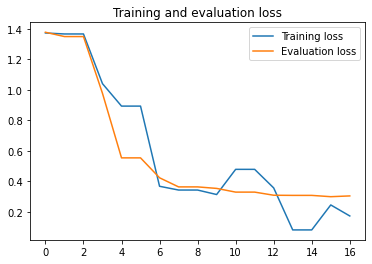

In [ ]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

In [ ]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(dev)
result

  0%|          | 0/226 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/29 [00:00<?, ?it/s]

{'mcc': 0.852293402324334, 'eval_loss': 0.30366746310530035}

In [ ]:
predicted, probabilities = model.predict(test.text.to_list())
test['predicted'] = predicted

  0%|          | 0/1498 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

In [ ]:
test.head(5)

,text,labels,predicted
0,\nAnd guess who's here in your place.\n\nPleas...,1,1
1,Does anyone know if any of Currier and Ives et...,1,1
2,=FLAME ON\n=\n=Reading through the posts about...,2,0
3,\nBut in this case I said I hoped that BCCI wa...,0,0
4,\nIn the kind I have made I used a Lite sour c...,2,2


In [ ]:
print(classification_report(test['labels'], test['predicted']))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       319
           1       0.90      0.92      0.91       389
           2       0.90      0.88      0.89       396
           3       0.82      0.83      0.82       394

    accuracy                           0.86      1498
   macro avg       0.86      0.86      0.86      1498
weighted avg       0.86      0.86      0.86      1498



### SVM 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.metrics import classification_report

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def lemmatize_stemming(text):
    return lemmatizer.lemmatize(text)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
           # result.append(token)
            result.append(lemmatize_stemming(token))
    return result

#### SVM without preprocessing

In [ ]:
train['text'].replace('', np.nan, inplace=True)
train.dropna(subset=['text'], inplace=True)
print(train)

                                                   text  labels
0     WHile we are on the subject of the shuttle sof...       3
1     There is a program called Graphic Workshop you...       1
3     My girlfriend is in pain from kidney stones. S...       2
4     I think that's the correct spelling..\n\tI am ...       2
5     Sorry to clog up the news group with this mess...       1
...                                                 ...     ...
2246  \n\n\n\n\n\n\n\n\nYeah, of course... The term ...       1
2247  \n\nI lived in Tokyo for a year and a half, an...       0
2248  Probably within 50 years, a new type of eugeni...       2
2249  \n\nBe sure to say "chronic" dizziness, not ju...       2
2250  \nI'm sure it is, and I am not amused.  Every ...       1

[2207 rows x 2 columns]


In [ ]:
vectorizer = CountVectorizer()
train_feats = vectorizer.fit_transform(train['text'])
vectorizer.get_feature_names_out()
train_features = train_feats.toarray()
print(len(train_features))

2207


In [ ]:
lin_clf = svm.LinearSVC()

In [ ]:
lin_clf.fit(train_features, train['labels'])

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [ ]:
test['text'].replace('', np.nan, inplace=True)
test.dropna(subset=['text'], inplace=True)

In [ ]:
test_feats = vectorizer.transform(test['text'])
test_features = test_feats.toarray()
print(len(test_features))
print(len(test['labels']))

1464
1464


In [ ]:
#This is the classification report of svm with no preprocessing of the text
print(classification_report(test['labels'], lin_clf.predict(test_features)))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73       313
           1       0.80      0.83      0.82       384
           2       0.78      0.73      0.75       384
           3       0.72      0.74      0.73       383

    accuracy                           0.76      1464
   macro avg       0.76      0.76      0.76      1464
weighted avg       0.76      0.76      0.76      1464



#### SVM with preprocessing

In [ ]:
processed_train = train['text'].map(preprocess)
processed_test = test['text'].map(preprocess)
processed_train[:10]

0     [subject, shuttle, software, happened, hypothe...
1     [program, called, graphic, workshop, ftp, wuar...
3     [girlfriend, pain, kidney, stone, say, medical...
4     [think, correct, spelling, looking, informatio...
5     [sorry, clog, news, group, message, wayne, rig...
6     [ed, campion, headquarters, washington, april,...
7     [zillion, line, response, article, apr, iti, o...
8     [algorithm, work, algorithm, attempt, outward,...
9                    [define, word, shatim, fasad, use]
10    [lewis, clark, college, recently, installed, d...
Name: text, dtype: object

In [ ]:
train['liststring'] = [', '.join(map(str, l)) for l in processed_train]
test['liststring'] = [', '.join(map(str, l)) for l in processed_test]

In [ ]:
print(train)
print(test)

In [ ]:
vectorizer = CountVectorizer()
train_feats2 = vectorizer.fit_transform(train['liststring'])
train_features2 = train_feats2.toarray()

test_feats2 = vectorizer.transform(test['liststring'])
test_features2 = test_feats2.toarray()

In [ ]:
lin_clf2 = svm.LinearSVC()
lin_clf2.fit(train_features2, train['labels'])

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [ ]:
#This is the classification report of svm with preprocessing of the text
print(classification_report(test['labels'], lin_clf2.predict(test_features2)))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       313
           1       0.81      0.84      0.83       384
           2       0.82      0.75      0.78       384
           3       0.74      0.75      0.74       383

    accuracy                           0.77      1464
   macro avg       0.77      0.77      0.77      1464
weighted avg       0.77      0.77      0.77      1464



* Fine-tune and examine the performance of another transformer-based pretrained language models, e.g., RoBERTa, XLNet

* Compare the performance of this model to the results achieved in Lab6.4-Topic-classification-BERT.ipynb and to a conventional machine learning approach (e.g., SVM, Naive Bayes) using bag-of-words or other engineered features of your choice. 
Describe the differences in performance in terms of Precision, Recall, and F1-score evaluation metrics.

## **Evaluation**

The following two figures show the training loss for both the training and evaluation loss for both the BERT and RoBERTa language models alongside their values for the Matthews correlation coefficient and the cross entropy loss for the validation (dev) set.

**BERT:**
<br>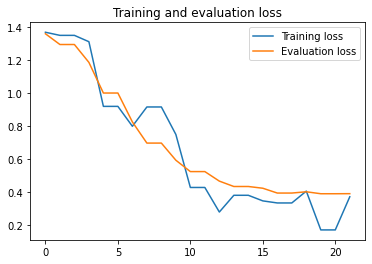
<br> {'mcc': 0.8240450771739839, 'eval_loss': 0.38973433395911905}

**RoBERTa:**
<br> 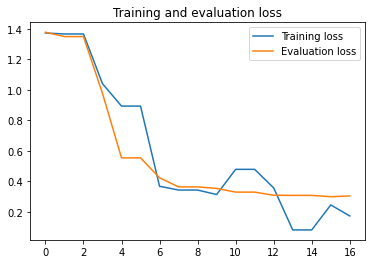
<br>`{'mcc': 0.852293402324334, 'eval_loss': 0.30366746310530035}`

Looking at the results above (those of BERT obtained by running Lab6.4), it can be observed that given the dataset used to perform the classification, the RoBERTa model performed slightly better than BERT. The mcc value for RoBERTa is slightly higher. While this difference isn't a very significant one, it still means it scored closer to 1 (of the values ranging from -1 to 1) which would indicate perfect predications. Moreover, the evaluation loss stabilizes around a value of 0.30 for RoBERTa, which is lower than the 0.39 for BERT. A smaller loss value indicates that the classifier is better at modeling the relationship between the input data and the output targets, meaning RoBERTa also scored better here. None of the models show any clear signs of overfitting when comparing the training and evaluation loss graphs. 

<br>To further compare the performance of these two language models, we take a look at their classification reports:


**BERT:**

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       319
           1       0.91      0.90      0.90       389
           2       0.92      0.88      0.90       396
           3       0.77      0.84      0.81       394

    accuracy                           0.86      1498
    macro avg      0.86      0.85      0.85      1498
    weighted avg   0.86      0.86      0.86      1498


**RoBERTa:**

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       319
           1       0.90      0.92      0.91       389
           2       0.90      0.88      0.89       396
           3       0.82      0.83      0.82       394

    accuracy                           0.86      1498
    macro avg      0.86      0.86      0.86      1498
    weighted avg   0.86      0.86      0.86      1498

Though the above reports show little to no difference in performace, they are in line with the results generated during the training phase in which we considered the training and evaluation loss. Looking at the precision (number of correctly classified positives wrt the predicted positives), we see that BERT managed to score better for topic 1 and 2 when comparing the scores to RoBERTa. On the other hand, if we look at how many topics were actually predicted correctly wrt the total number of instances that actually belong to that class (recall), BERT and RoBERTa score similar with only very slight differences which is actually the same when considering precision. Finally, the f1-scores also show little to no differences and this can also be seen when taking into account the observed accuracy scores that are equal (as well as similar macro/weighted averages). Considering the scores alone for each classifier, we can conclude that their performance is pretty good with a decent accuracy score and most scores being above 0.8. 

To firther evaluate the performances and see whether the above two language models did really perform well, they are compared to a simpler classifier, namely the SVM. The following classification report shows the results of applying the SVM classifier (with preprocessing of the text) to the dataset:

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       313
           1       0.81      0.84      0.83       384
           2       0.82      0.75      0.78       384
           3       0.74      0.75      0.74       383

    accuracy                           0.77      1464
    macro avg      0.77      0.77      0.77      1464
    weighted avg   0.77      0.77      0.77      1464

By observing the classification report of the SVM model we can conclude that it performed significantly worse than both the BERT and the BERTA models. The overall accuracy of 0.77 for SVM is significantly lower than the accuracy of BERT and BERTA with 0.86. As for the rest of the macro/weighted averages for all topics, the performance of the SVM model is worse than the performance of the two other models. The SVM averages are lower by 0.09/0.08 than the BERT/BERTA's averages. It does go with our expected results as BERT and BERTA are models that were developed especially for natural language processing. These models take into account all words in the sequence and use their context while SVM is a more general model that classifies using supervised methods on the training data. This can be seen as it makes more during the classification both on a class (precision) as well as overall document (recall) level. It is important to mention that the data set was in the English language, for this language the BERT and BERTA models are very developed. On data sets in other languages, we can expect different results between the performance of the SVM and these two models. Additionally, a more balanced data set with more training data would have improved the performance of the SVM model but for this given data there is no doubt that BERT and BERTA are better performing.
